In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.onnx
import onnx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
import json
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

import kagglehub

# Télécharger le dataset
print("📥 Téléchargement du dataset de logos...")
path = kagglehub.dataset_download("linkanjarad/famous-brand-logos")
print("📁 Chemin du dataset:", path)

📥 Téléchargement du dataset de logos...
📁 Chemin du dataset: C:\Users\qpach\.cache\kagglehub\datasets\linkanjarad\famous-brand-logos\versions\2


In [10]:
dataset_path = Path(path)
print(f"📊 Structure du dataset:")
for item in dataset_path.rglob("*"):
    if item.is_file():
        print(f"📄 {item.relative_to(dataset_path)}")
    elif item.is_dir():
        print(f"📁 {item.relative_to(dataset_path)}/")

# Compter les images par marque
brand_folders = [d for d in dataset_path.iterdir() if d.is_dir()]
print(f"\n🏷️  Marques trouvées: {len(brand_folders)}")

brand_counts = {}
total_images = 0
for brand_folder in brand_folders:
    image_files = list(brand_folder.glob("*.jpg")) + list(brand_folder.glob("*.png")) + list(brand_folder.glob("*.jpeg"))
    brand_counts[brand_folder.name] = len(image_files)
    total_images += len(image_files)
    print(f"   • {brand_folder.name}: {len(image_files)} images")

print(f"\n📈 Total: {total_images} images")

📊 Structure du dataset:
📁 logos/
📁 logos\Amazon/
📁 logos\American Express/
📁 logos\Apple/
📁 logos\AT_T/
📁 logos\BMW/
📁 logos\Budweiser/
📁 logos\Cisco/
📁 logos\Coca-Cola/
📁 logos\Disney/
📁 logos\Facebook/
📁 logos\GE/
📁 logos\Google/
📁 logos\Honda/
📁 logos\IBM/
📁 logos\Intel/
📁 logos\Louis Vuitton/
📁 logos\Marlboro/
📁 logos\McDonald_s/
📁 logos\Mercedes-Benz/
📁 logos\Microsoft/
📁 logos\Netflix/
📁 logos\NIKE/
📁 logos\Oracle/
📁 logos\Samsung/
📁 logos\SAP/
📁 logos\Toyota/
📁 logos\Verizon/
📁 logos\Visa/
📁 logos\Walmart/
📄 logos\Amazon\Amazon logo0.jpg
📄 logos\Amazon\Amazon logo1.jpg
📄 logos\Amazon\Amazon logo10.jpg
📄 logos\Amazon\Amazon logo11.jpg
📄 logos\Amazon\Amazon logo12.jpg
📄 logos\Amazon\Amazon logo13.jpg
📄 logos\Amazon\Amazon logo14.jpg
📄 logos\Amazon\Amazon logo15.jpg
📄 logos\Amazon\Amazon logo16.jpg
📄 logos\Amazon\Amazon logo17.jpg
📄 logos\Amazon\Amazon logo18.jpg
📄 logos\Amazon\Amazon logo19.jpg
📄 logos\Amazon\Amazon logo2.jpg
📄 logos\Amazon\Amazon logo20.jpg
📄 logos\Amazon\Amazon 

In [ ]:
class LogoDatasetTop10(Dataset):
    def __init__(self, root_dir, transform=None, max_images_per_brand=None, top_k_brands=10):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Obtenir toutes les marques et compter leurs images
        brand_folders = [d for d in self.root_dir.iterdir() if d.is_dir()]
        brand_counts = {}
        
        print(f"🔍 Analyse des {len(brand_folders)} marques pour sélectionner le top {top_k_brands}...")
        
        # Compter les images pour chaque marque
        for brand_folder in brand_folders:
            brand_name = brand_folder.name
            extensions = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
            image_paths = []
            for ext in extensions:
                image_paths.extend(list(brand_folder.glob(ext)))
            brand_counts[brand_name] = len(image_paths)
            print(f"   • {brand_name}: {len(image_paths)} images")
        
        # Trier les marques par nombre d'images (décroissant) et prendre le top K
        sorted_brands = sorted(brand_counts.items(), key=lambda x: x[1], reverse=True)
        top_brands = sorted_brands[:top_k_brands]
        
        print(f"\n🏆 TOP {top_k_brands} MARQUES SÉLECTIONNÉES:")
        for i, (brand_name, count) in enumerate(top_brands, 1):
            print(f"   {i:2d}. {brand_name}: {count} images")
        
        # Créer le mapping pour seulement les top K marques
        selected_brand_names = [brand_name for brand_name, _ in top_brands]
        self.brand_to_idx = {brand_name: idx for idx, brand_name in enumerate(selected_brand_names)}
        self.idx_to_brand = {idx: brand_name for brand_name, idx in self.brand_to_idx.items()}
        
        print(f"\n🏷️  Classes finales: {len(self.brand_to_idx)}")
        
        # Charger les images seulement pour les marques sélectionnées
        for brand_name in selected_brand_names:
            brand_folder = self.root_dir / brand_name
            brand_idx = self.brand_to_idx[brand_name]
            
            # Extensions supportées
            extensions = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
            image_paths = []
            for ext in extensions:
                image_paths.extend(list(brand_folder.glob(ext)))
            
            # Limiter le nombre d'images par marque si spécifié
            if max_images_per_brand and len(image_paths) > max_images_per_brand:
                image_paths = image_paths[:max_images_per_brand]
            
            for img_path in image_paths:
                self.images.append(str(img_path))
                self.labels.append(brand_idx)
        
        print(f"\n📊 Dataset final: {len(self.images)} images pour {len(self.brand_to_idx)} marques")
        
        # Afficher la distribution finale
        label_counts = Counter(self.labels)
        print(f"\n📈 Distribution finale:")
        for brand_idx, count in sorted(label_counts.items()):
            brand_name = self.idx_to_brand[brand_idx]
            print(f"   • {brand_name}: {count} images")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Charger l'image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"❌ Erreur chargement {img_path}: {e}")
            # Retourner une image noire en cas d'erreur
            image = Image.new('RGB', (224, 224), color='black')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [ ]:
print("🔍 DIAGNOSTIC DU DATASET - TOP 10 CLASSES")
print("="*60)
print(f"📁 Chemin du dataset: {dataset_path}")
print(f"📂 Le chemin existe: {dataset_path.exists()}")
print(f"📂 C'est un dossier: {dataset_path.is_dir()}")

if dataset_path.exists():
    print(f"\n📋 Contenu du dossier principal:")
    items = list(dataset_path.iterdir())
    print(f"Nombre d'éléments trouvés: {len(items)}")
    
    brand_folders_found = []
    
    for item in items:
        if item.is_dir():
            # Compter les images dans chaque dossier
            image_files = []
            for ext in ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]:
                image_files.extend(list(item.glob(ext)))
            print(f"📁 {item.name}/ → {len(image_files)} images")
            if len(image_files) > 0:
                brand_folders_found.append(item)
        else:
            print(f"📄 {item.name}")
    
    # Si pas de dossiers avec images, chercher plus profond
    if len(brand_folders_found) == 0:
        print(f"\n🔍 Aucune image trouvée dans les dossiers principaux. Recherche plus profonde...")
        subdirs = [d for d in dataset_path.iterdir() if d.is_dir()]
        
        for subdir in subdirs:
            print(f"\n📂 Exploration de: {subdir.name}")
            sub_items = list(subdir.iterdir())
            sub_brand_folders = []
            
            for sub_item in sub_items:
                if sub_item.is_dir():
                    sub_images = []
                    for ext in ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]:
                        sub_images.extend(list(sub_item.glob(ext)))
                    if len(sub_images) > 0:
                        print(f"   📁 {sub_item.name}/ → {len(sub_images)} images")
                        sub_brand_folders.append(sub_item)
            
            if len(sub_brand_folders) > 0:
                print(f"\n💡 SOLUTION TROUVÉE! Les vraies données sont dans: {subdir}")
                print(f"✅ {len(sub_brand_folders)} dossiers de marques trouvés")
                print(f"\n🔧 CORRECTION AUTOMATIQUE DU CHEMIN:")
                dataset_path = subdir
                print(f"Nouveau dataset_path: {dataset_path}")
                break
    else:
        print(f"\n✅ {len(brand_folders_found)} dossiers de marques trouvés dans le dossier principal")

else:
    print("❌ Le chemin du dataset n'existe pas!")
    print("Vérifiez que kagglehub a bien téléchargé les données")

print("\n" + "="*60)

# Transformations pour l'entraînement (avec augmentation)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Transformations pour la validation (sans augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Créer le dataset complet avec TOP 10 classes seulement
print("📊 Création du dataset avec TOP 10 classes...")
full_dataset = LogoDatasetTop10(dataset_path, transform=None, max_images_per_brand=500, top_k_brands=10)

# Vérifier que le dataset n'est pas vide
if len(full_dataset) == 0:
    print("❌ ERREUR: Dataset toujours vide après diagnostic!")
    print("Causes possibles:")
    print("1. Le dataset Kaggle n'a pas été téléchargé correctement")
    print("2. Les images sont dans un format non supporté")
    print("3. Structure de dossiers différente de celle attendue")
    print("\nVérifiez manuellement le contenu des dossiers.")
    raise ValueError("Dataset vide - arrêt du processus")

print(f"✅ Dataset créé avec {len(full_dataset)} images")

# Sauvegarder le mapping des classes (TOP 10)
class_mapping = {
    'brand_to_idx': full_dataset.brand_to_idx,
    'idx_to_brand': full_dataset.idx_to_brand,
    'num_classes': len(full_dataset.brand_to_idx)
}

with open('logo_classes_top10.json', 'w') as f:
    json.dump(class_mapping, f, indent=2)
print("💾 Mapping des classes TOP 10 sauvegardé: logo_classes_top10.json")

# Split train/validation
from torch.utils.data import random_split

dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

print(f"📊 Split proposé: {train_size} train, {val_size} validation")

generator = torch.Generator().manual_seed(42)
train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size], generator=generator)

print(f"📈 Split effectué: {len(train_indices)} train, {len(val_indices)} validation")

# Créer des datasets séparés avec les bonnes transformations
class TransformDataset(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        base_idx = self.indices[idx]
        image_path = self.base_dataset.images[base_idx]
        label = self.base_dataset.labels[base_idx]
        
        # Charger l'image
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"❌ Erreur chargement {image_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')
        
        # Appliquer les transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Créer les datasets avec transformations
train_dataset = TransformDataset(full_dataset, train_indices, train_transform)
val_dataset = TransformDataset(full_dataset, val_indices, val_transform)

print(f"✅ Datasets avec transformations créés:")
print(f"   • Train: {len(train_dataset)} images")
print(f"   • Validation: {len(val_dataset)} images")

# Afficher le récapitulatif des classes sélectionnées
print(f"\n🎯 RÉCAPITULATIF - TOP 10 CLASSES:")
print("="*50)
for idx, brand_name in full_dataset.idx_to_brand.items():
    count = sum(1 for label in full_dataset.labels if label == idx)
    print(f"{idx:2d}. {brand_name}: {count} images")
print("="*50)

🔍 DIAGNOSTIC DU DATASET - TOP 10 CLASSES
📁 Chemin du dataset: C:\Users\qpach\.cache\kagglehub\datasets\linkanjarad\famous-brand-logos\versions\2
📂 Le chemin existe: True
📂 C'est un dossier: True

📋 Contenu du dossier principal:
Nombre d'éléments trouvés: 1
📁 logos/ → 0 images

🔍 Aucune image trouvée dans les dossiers principaux. Recherche plus profonde...

📂 Exploration de: logos
   📁 Amazon/ → 196 images
   📁 American Express/ → 196 images
   📁 Apple/ → 196 images
   📁 AT_T/ → 160 images
   📁 BMW/ → 196 images
   📁 Budweiser/ → 196 images
   📁 Cisco/ → 194 images
   📁 Coca-Cola/ → 196 images
   📁 Disney/ → 196 images
   📁 Facebook/ → 194 images
   📁 GE/ → 190 images
   📁 Google/ → 196 images
   📁 Honda/ → 196 images
   📁 IBM/ → 194 images
   📁 Intel/ → 196 images
   📁 Louis Vuitton/ → 196 images
   📁 Marlboro/ → 196 images
   📁 McDonald_s/ → 196 images
   📁 Mercedes-Benz/ → 168 images
   📁 Microsoft/ → 196 images
   📁 Netflix/ → 196 images
   📁 NIKE/ → 196 images
   📁 Oracle/ → 194 im

In [ ]:
batch_size = 32
num_workers = 0  # Mis à 0 pour éviter les problèmes multiprocessing

# Vérifier une dernière fois que les datasets ne sont pas vides
print(f"🔍 Vérification finale - TOP 10 CLASSES:")
print(f"   • Train dataset: {len(train_dataset)} échantillons")
print(f"   • Val dataset: {len(val_dataset)} échantillons")
print(f"   • Nombre de classes: {len(full_dataset.brand_to_idx)}")

if len(train_dataset) == 0:
    raise ValueError("❌ Train dataset est vide!")
if len(val_dataset) == 0:
    raise ValueError("❌ Validation dataset est vide!")

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True
)

print(f"🔄 DataLoaders créés avec succès:")
print(f"   • Train: {len(train_loader)} batches de {batch_size}")
print(f"   • Validation: {len(val_loader)} batches de {batch_size}")

# Test rapide pour vérifier que ça fonctionne
try:
    print("\n🧪 Test du train_loader...")
    train_batch = next(iter(train_loader))
    print(f"✅ Batch de train: images {train_batch[0].shape}, labels {train_batch[1].shape}")
    
    print("🧪 Test du val_loader...")
    val_batch = next(iter(val_loader))
    print(f"✅ Batch de validation: images {val_batch[0].shape}, labels {val_batch[1].shape}")
    
    print(f"🏷️ Exemple de labels dans le batch: {train_batch[1][:5].tolist()}")
    print(f"🏷️ Labels max dans le dataset: {max(full_dataset.labels)} (attendu: {len(full_dataset.brand_to_idx)-1})")
    
except Exception as e:
    print(f"❌ Erreur lors du test des DataLoaders: {e}")
    raise

print("\n🎉 DataLoaders pour TOP 10 classes prêts!")

🔍 Vérification finale - TOP 10 CLASSES:
   • Train dataset: 1568 échantillons
   • Val dataset: 392 échantillons
   • Nombre de classes: 10
🔄 DataLoaders créés avec succès:
   • Train: 49 batches de 32
   • Validation: 13 batches de 32

🧪 Test du train_loader...
✅ Batch de train: images torch.Size([32, 3, 224, 224]), labels torch.Size([32])
🧪 Test du val_loader...
✅ Batch de validation: images torch.Size([32, 3, 224, 224]), labels torch.Size([32])
🏷️ Exemple de labels dans le batch: [0, 8, 6, 0, 8]
🏷️ Labels max dans le dataset: 9 (attendu: 9)

🎉 DataLoaders pour TOP 10 classes prêts!


In [14]:
class LogoClassifier(nn.Module):
    def __init__(self, num_classes):
        super(LogoClassifier, self).__init__()
        
        # Bloc convolutionnel 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloc convolutionnel 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloc convolutionnel 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloc convolutionnel 4
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Couches fully connected
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.classifier(x)
        return x


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")

# CHANGEMENT ICI: Nombre de classes = 10 maintenant
num_classes = len(full_dataset.brand_to_idx)
print(f"🎯 Nombre de classes: {num_classes}")

model = LogoClassifier(num_classes).to(device)

# Afficher le nombre de paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Paramètres: {total_params:,} total, {trainable_params:,} entraînables")

# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Fonction d'entraînement
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if batch_idx % 20 == 0:
            print(f'   Batch {batch_idx}/{len(train_loader)}: Loss={loss.item():.4f}, Acc={100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Fonction de validation
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

🖥️  Device: cuda
🎯 Nombre de classes: 10
📊 Paramètres: 30,910,282 total, 30,910,282 entraînables


In [ ]:
num_epochs = 20
best_val_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

print(f"🚀 Début de l'entraînement - TOP {num_classes} CLASSES...")

for epoch in range(num_epochs):
    print(f"\n📅 Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Entraînement
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"🏋️  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    
    # Validation
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    print(f"✅ Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    
    # Sauvegarder les métriques
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Scheduler
    scheduler.step(val_acc)
    
    # Sauvegarder le meilleur modèle - CHANGEMENT ICI
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_logo_model_top10.pth')
        print(f"💾 Nouveau meilleur modèle sauvegardé! Acc: {val_acc:.2f}%")

print(f"\n🎉 Entraînement terminé! Meilleure accuracy: {best_val_acc:.2f}%")

🚀 Début de l'entraînement - TOP 10 CLASSES...

📅 Epoch 1/5
--------------------------------------------------
   Batch 0/49: Loss=1.8655, Acc=37.50%
   Batch 20/49: Loss=1.6790, Acc=36.01%
   Batch 40/49: Loss=1.9268, Acc=35.44%
🏋️  Train - Loss: 1.8461, Acc: 35.59%
✅ Val   - Loss: 1.7935, Acc: 37.24%
💾 Nouveau meilleur modèle sauvegardé! Acc: 37.24%

📅 Epoch 2/5
--------------------------------------------------
   Batch 0/49: Loss=1.6190, Acc=43.75%
   Batch 20/49: Loss=1.5372, Acc=36.16%
   Batch 40/49: Loss=1.9865, Acc=33.61%
🏋️  Train - Loss: 1.8263, Acc: 33.29%
✅ Val   - Loss: 1.6997, Acc: 38.27%
💾 Nouveau meilleur modèle sauvegardé! Acc: 38.27%

📅 Epoch 3/5
--------------------------------------------------
   Batch 0/49: Loss=1.6598, Acc=37.50%
   Batch 20/49: Loss=1.8282, Acc=34.67%
   Batch 40/49: Loss=1.6509, Acc=35.21%
🏋️  Train - Loss: 1.7746, Acc: 36.03%
✅ Val   - Loss: 1.7505, Acc: 36.73%

📅 Epoch 4/5
--------------------------------------------------
   Batch 0/49: Loss

In [16]:
# Fonction de test adaptée pour le modèle de reconnaissance de logos

def test(loader: DataLoader, model: nn.Module, criterion: nn.Module, device: torch.device):
    """
    Teste le modèle sur un DataLoader donné
    
    Args:
        loader: DataLoader contenant les données de test
        model: Modèle à tester
        criterion: Fonction de perte
        device: Device (CPU ou GPU)
    
    Returns:
        tuple: (average_loss, accuracy)
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0
    correct_predictions = 0
    
    print(f"🧪 Test en cours sur {len(loader)} batches...")
    
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred, y)
            
            batch_size = X.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            _, predicted = torch.max(y_pred, 1)
            correct_predictions += (predicted == y).sum().item()
            
            # Affichage du progrès tous les 10 batches
            if batch_idx % 10 == 0:
                current_acc = correct_predictions / total_samples * 100 if total_samples > 0 else 0
                print(f"   Batch {batch_idx}/{len(loader)}: Acc temporaire = {current_acc:.2f}%")
    
    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples * 100
    
    print(f"\n📊 RÉSULTATS DU TEST:")
    print(f"   • Average Loss: {average_loss:.4f}")
    print(f"   • Accuracy: {accuracy:.2f}%")
    print(f"   • Échantillons testés: {total_samples}")
    print(f"   • Prédictions correctes: {correct_predictions}")
    
    return average_loss, accuracy


def test_with_class_details(loader: DataLoader, model: nn.Module, criterion: nn.Module, 
                           device: torch.device, class_mapping: dict):
    """
    Version étendue avec détails par classe
    
    Args:
        loader: DataLoader contenant les données de test
        model: Modèle à tester
        criterion: Fonction de perte
        device: Device (CPU ou GPU)
        class_mapping: Dictionnaire avec le mapping des classes
    
    Returns:
        tuple: (average_loss, accuracy, class_accuracies)
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0
    correct_predictions = 0
    
    num_classes = len(class_mapping['brand_to_idx'])
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    print(f"🧪 Test détaillé en cours sur {len(loader)} batches...")
    
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred, y)
            
            batch_size = X.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            _, predicted = torch.max(y_pred, 1)
            correct_predictions += (predicted == y).sum().item()
            
            # Compter par classe
            for i in range(y.size(0)):
                label = y[i].item()
                class_correct[label] += (predicted[i] == y[i]).item()
                class_total[label] += 1
            
            # Affichage du progrès
            if batch_idx % 10 == 0:
                current_acc = correct_predictions / total_samples * 100 if total_samples > 0 else 0
                print(f"   Batch {batch_idx}/{len(loader)}: Acc temporaire = {current_acc:.2f}%")
    
    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples * 100
    
    # Calculer accuracy par classe
    class_accuracies = {}
    print(f"\n📊 RÉSULTATS DÉTAILLÉS:")
    print(f"   • Average Loss: {average_loss:.4f}")
    print(f"   • Accuracy globale: {accuracy:.2f}%")
    print(f"   • Échantillons testés: {total_samples}")
    
    print(f"\n📋 Accuracy par classe:")
    for i in range(num_classes):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i] / class_total[i]
            brand_name = class_mapping['idx_to_brand'][i]
            class_accuracies[brand_name] = class_acc
            print(f"   {i:2d}. {brand_name:15s}: {class_acc:6.2f}% ({class_correct[i]:3d}/{class_total[i]:3d})")
        else:
            brand_name = class_mapping['idx_to_brand'][i]
            class_accuracies[brand_name] = 0.0
            print(f"   {i:2d}. {brand_name:15s}: Aucun échantillon")
    
    return average_loss, accuracy, class_accuracies


# Exemple d'utilisation pour votre notebook:

# Test simple
print("🚀 Test du modèle sur les données de validation...")
test_loss, test_accuracy = test(val_loader, model, criterion, device)

# Test avec chargement du meilleur modèle
print("\n🚀 Test du meilleur modèle sauvegardé...")
# Charger le meilleur modèle
model.load_state_dict(torch.load('best_logo_model_top10.pth', map_location=device))
test_loss, test_accuracy = test(val_loader, model, criterion, device)

# Test détaillé avec statistiques par classe
print("\n🚀 Test détaillé avec stats par classe...")
test_loss, test_accuracy, class_accs = test_with_class_details(
    val_loader, model, criterion, device, class_mapping
)

# Si vous avez un dataset de test séparé, vous pouvez l'utiliser ainsi:
# test_loss, test_accuracy = test(test_loader, model, criterion, device)

🚀 Test du modèle sur les données de validation...
🧪 Test en cours sur 13 batches...
   Batch 0/13: Acc temporaire = 9.38%
   Batch 10/13: Acc temporaire = 10.80%

📊 RÉSULTATS DU TEST:
   • Average Loss: 2.3022
   • Accuracy: 11.22%
   • Échantillons testés: 392
   • Prédictions correctes: 44

🚀 Test du meilleur modèle sauvegardé...
🧪 Test en cours sur 13 batches...
   Batch 0/13: Acc temporaire = 37.50%
   Batch 10/13: Acc temporaire = 34.66%

📊 RÉSULTATS DU TEST:
   • Average Loss: 1.9417
   • Accuracy: 33.93%
   • Échantillons testés: 392
   • Prédictions correctes: 133

🚀 Test détaillé avec stats par classe...
🧪 Test détaillé en cours sur 13 batches...
   Batch 0/13: Acc temporaire = 37.50%
   Batch 10/13: Acc temporaire = 34.66%

📊 RÉSULTATS DÉTAILLÉS:
   • Average Loss: 1.9417
   • Accuracy globale: 33.93%
   • Échantillons testés: 392

📋 Accuracy par classe:
    0. Amazon         :  12.90% (  4/ 31)
    1. American Express:   0.00% (  0/ 55)
    2. Apple          :  66.67% ( 28/ 

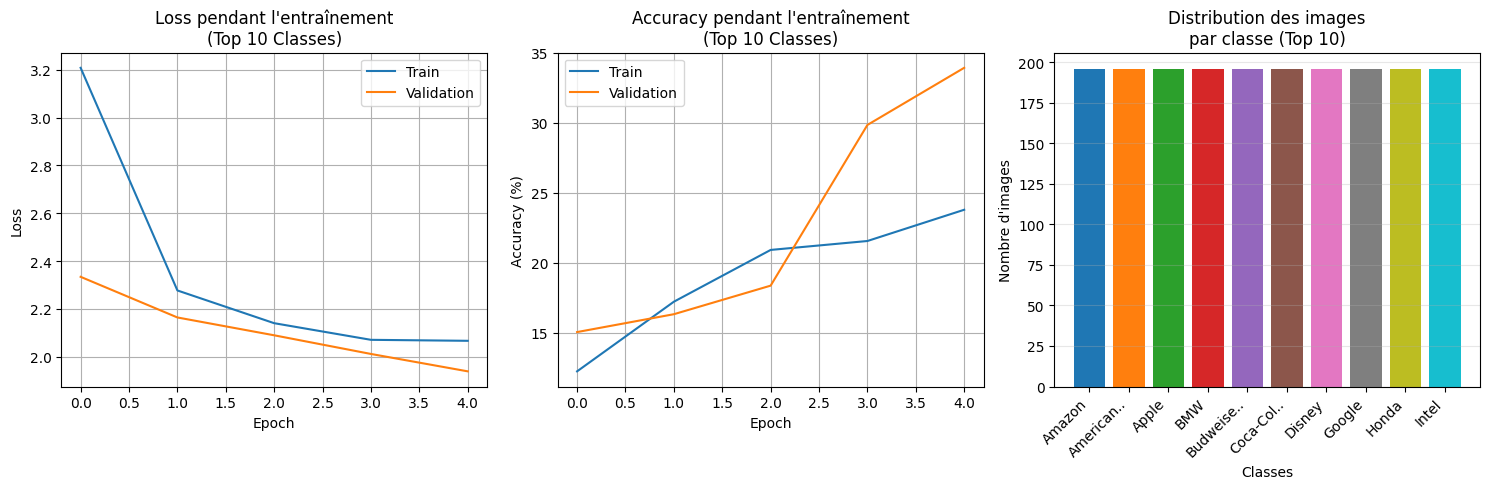

📊 Graphiques sauvegardés: training_curves_top10.png


In [17]:
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss pendant l\'entraînement\n(Top 10 Classes)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy pendant l\'entraînement\n(Top 10 Classes)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Distribution des classes
plt.subplot(1, 3, 3)
class_names = [full_dataset.idx_to_brand[i] for i in range(num_classes)]
class_counts = [sum(1 for label in full_dataset.labels if label == i) for i in range(num_classes)]
bars = plt.bar(range(num_classes), class_counts, color=plt.cm.tab10(range(num_classes)))
plt.title('Distribution des images\npar classe (Top 10)')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.xticks(range(num_classes), [name[:8] + '..' if len(name) > 8 else name for name in class_names], 
rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('training_curves_top10.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"📊 Graphiques sauvegardés: training_curves_top10.png")

In [18]:
print("📤 Export du modèle TOP 10 vers ONNX...")

# Charger le meilleur modèle - CHANGEMENT ICI
model.load_state_dict(torch.load('best_logo_model_top10.pth', map_location=device))
model.eval()

# Créer une entrée factice
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Test du modèle
with torch.no_grad():
    dummy_output = model(dummy_input)
    print(f"✅ Test modèle - Sortie: {dummy_output.shape}")
    print(f"✅ Classes prédites possibles: 0 à {num_classes-1}")

# Export ONNX - CHANGEMENT ICI
torch.onnx.export(
    model,
    dummy_input,
    "logo_model_top10.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print("✅ Modèle TOP 10 exporté: logo_model_top10.onnx")

📤 Export du modèle TOP 10 vers ONNX...
✅ Test modèle - Sortie: torch.Size([1, 10])
✅ Classes prédites possibles: 0 à 9
✅ Modèle TOP 10 exporté: logo_model_top10.onnx


In [19]:
try:
    # CHANGEMENT ICI
    onnx_model = onnx.load("logo_model_top10.onnx")
    onnx.checker.check_model(onnx_model)
    print("✅ Modèle ONNX vérifié!")
    
    print(f"📊 Informations ONNX:")
    print(f"   • Version: {onnx_model.opset_import[0].version}")
    print(f"   • Entrées: {[i.name for i in onnx_model.graph.input]}")
    print(f"   • Sorties: {[o.name for o in onnx_model.graph.output]}")
    
except Exception as e:
    print(f"❌ Erreur ONNX: {e}")

try:
    import onnxruntime as ort
    
    # Test ONNX Runtime - CHANGEMENT ICI
    ort_session = ort.InferenceSession("logo_model_top10.onnx")
    ort_inputs = {ort_session.get_inputs()[0].name: dummy_input.cpu().numpy()}
    ort_outputs = ort_session.run(None, ort_inputs)
    
    print("✅ Test ONNX Runtime réussi!")
    
    # Comparer les sorties
    pytorch_output = dummy_output.cpu().numpy()
    onnx_output = ort_outputs[0]
    diff = np.abs(pytorch_output - onnx_output).max()
    print(f"📊 Différence max PyTorch vs ONNX: {diff}")
    
except ImportError:
    print("ℹ️  ONNX Runtime non installé")
except Exception as e:
    print(f"❌ Erreur test ONNX Runtime: {e}")

# Résumé final - CHANGEMENTS ICI
print("\n" + "="*70)
print("🎉 ENTRAÎNEMENT TOP 10 LOGOS TERMINÉ!")
print("="*70)
print("📁 Fichiers générés:")
print("   • best_logo_model_top10.pth (modèle PyTorch)")
print("   • logo_model_top10.onnx (modèle web)")
print("   • logo_classes_top10.json (mapping des 10 classes)")
print("   • training_curves_top10.png (courbes d'entraînement)")

print(f"\n🏆 Résultats:")
print(f"   • Meilleure accuracy: {best_val_acc:.2f}%")
print(f"   • Nombre de classes: {num_classes} (vs 29 initialement)")
print(f"   • Dataset: {len(full_dataset)} images")

print(f"\n🎯 TOP 10 CLASSES ENTRAÎNÉES:")
for idx, brand_name in full_dataset.idx_to_brand.items():
    count = sum(1 for label in full_dataset.labels if label == idx)
    print(f"   {idx:2d}. {brand_name}: {count} images")

print("\n💡 Prochaine étape: Utiliser le modèle avec logo_model_top10.onnx!")
print("="*70)

✅ Modèle ONNX vérifié!
📊 Informations ONNX:
   • Version: 11
   • Entrées: ['input']
   • Sorties: ['output']
✅ Test ONNX Runtime réussi!
📊 Différence max PyTorch vs ONNX: 2.384185791015625e-07

🎉 ENTRAÎNEMENT TOP 10 LOGOS TERMINÉ!
📁 Fichiers générés:
   • best_logo_model_top10.pth (modèle PyTorch)
   • logo_model_top10.onnx (modèle web)
   • logo_classes_top10.json (mapping des 10 classes)
   • training_curves_top10.png (courbes d'entraînement)

🏆 Résultats:
   • Meilleure accuracy: 33.93%
   • Nombre de classes: 10 (vs 29 initialement)
   • Dataset: 1960 images

🎯 TOP 10 CLASSES ENTRAÎNÉES:
    0. Amazon: 196 images
    1. American Express: 196 images
    2. Apple: 196 images
    3. BMW: 196 images
    4. Budweiser: 196 images
    5. Coca-Cola: 196 images
    6. Disney: 196 images
    7. Google: 196 images
    8. Honda: 196 images
    9. Intel: 196 images

💡 Prochaine étape: Utiliser le modèle avec logo_model_top10.onnx!
